# BNN Regression on Molecules

Here we will compare the regression of molecules for the given datasets using BNN with GPs. Here we rely on Bayesian linear layers from Bayesian-Torch (https://github.com/IntelLabs/bayesian-torch).

The densely connected network will have weight *distributions* rather than deterministic weights. The uncertainty of the model will be obtained by repeatedly sampling the network for predictions.

## Set up datasets and import packages

In [3]:
# import os, sys
# sys.path.append('..')

import sklearn
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data

import pandas as pd
import numpy as np
import rdkit.Chem.AllChem as Chem
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline  

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from bayesian_torch.layers import LinearFlipout, LinearReparameterization

In [4]:
# set paths
dataset_paths = {
    "Photoswitch": "../data/property_prediction/photoswitches.csv",
    "ESOL": "../data/property_prediction/ESOL.csv",
    "FreeSolv": "../data/property_prediction/FreeSolv.csv",
    "Lipophilicity": "../data/property_prediction/Lipophilicity.csv",
}
    

## Create model


In [5]:
class BNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.layer1 = LinearReparameterization(input_dim, hidden_dim)
        self.layerf = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        kl_sum = 0
        x, kl = self.layer1(x)
        kl_sum += kl
        x = F.relu(x)
        x = self.layerf(x)
        return x, kl_sum

In [6]:
def nlpd(y, y_pred, y_std):
    nld = 0
    for y_true, mu, std in zip(y.ravel(), y_pred.ravel(), y_std.ravel()):
        nld  += -norm(mu, std).logpdf(y_true)
    return nld / len(y)

def predict(regressor, X, samples = 100):
    preds = [regressor(X)[0] for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    var = preds.var(axis=0)
    return means, var

In [9]:
from tqdm import tqdm
import copy

def evaluate_model(X, y, n_epochs=100, n_trials=20, kld_beta = 1., verbose=True):
    test_set_size = 0.2
    batch_size = 32
    
    r2_list = []
    rmse_list = []
    mae_list = []
    nlpd_list = []
    
    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)
    
    mae_confidence_list = np.zeros((n_trials, n_test))
    
    device = torch.device('cpu') # torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Device being used: {device}')
    
    print('\nBeginning training loop...')

    for i in range(0, n_trials):
        
        print(f'Starting trial {i}')
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)

        #  We standardise the outputs but leave the inputs unchanged
        _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        # Convert numpy arrays to PyTorch tensors and flatten the label vectors
        X_train = torch.tensor(X_train, dtype=torch.float).to(device)
        X_test = torch.tensor(X_test, dtype=torch.float).to(device)
        y_train = torch.tensor(y_train, dtype=torch.float).to(device)
        y_test = torch.tensor(y_test, dtype=torch.float).to(device)

        model = BNN(X_train.shape[-1], 100).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.MSELoss()
        
        ds_train = torch.utils.data.TensorDataset(X_train, y_train)
        dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
        
        training_loss = []
    
        status = {}
        best_loss = np.inf
        patience = 50
        count = 0
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            running_kld_loss = 0
            running_mse_loss = 0
            running_loss = 0
            for datapoints, labels in dataloader_train:
                optimizer.zero_grad()
                
                output, kl = model(datapoints)
                
                # calculate loss with kl term for Bayesian layers
                mse_loss = criterion(output, labels)
                loss = mse_loss + kl * kld_beta / batch_size
                
                loss.backward()
                optimizer.step()
                
                running_mse_loss += mse_loss.detach().numpy()
                running_kld_loss += kl.detach().numpy()
                running_loss += loss.detach().numpy()
                
            status.update({
                'Epoch': epoch, 
                'loss': running_loss/len(dataloader_train),
                'kl': running_kld_loss/len(dataloader_train),
                'mse': running_mse_loss/len(dataloader_train)
            })
            training_loss.append(status)
            pbar.set_postfix(status)
            
            with torch.no_grad():
                y_pred, y_var = predict(model, X_test)
                val_loss = criterion(y_pred, y_test)
                val_loss = val_loss.detach().numpy()
                status.update({'val_loss': val_loss})
                
                if best_loss > val_loss:
                    best_loss = val_loss
                    best_model = copy.deepcopy(model)
                    count = 0
                else:
                    count += 1
                
                if count >= patience:
                    if verbose: print(f'Early stopping reached! Best validation loss {best_loss}')
                    break 
            
            pbar.set_postfix(status)

        # Get into evaluation (predictive posterior) mode
        model = best_model
        model.eval()
        
        with torch.no_grad():
            # mean and variance by sampling
            y_pred, y_var = predict(model, X_test, samples=100)
            
        uq_nlpd = nlpd(y_test.detach(), y_pred.detach(), np.sqrt(y_var.detach()))
        if verbose: print(f'NLPD: {uq_nlpd}')

        # Transform back to real data space to compute metrics and detach gradients.
        y_pred = y_scaler.inverse_transform(y_pred.detach())
        y_test = y_scaler.inverse_transform(y_test.detach())

        # Compute scores for confidence curve plotting.
        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence
            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)
        nlpd_list.append(uq_nlpd)
        
    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)
    nlpd_list = np.array(nlpd_list)
        
    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list)))) 
    print("mean NLPD: {:.4f} +- {:.4f}\n".format(np.mean(nlpd_list), np.std(nlpd_list)/np.sqrt(len(nlpd_list)))) 
    print()
    
    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std
    
    fig = plt.figure()
    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    
    results = {
        'confidence_percentiles': confidence_percentiles,
        'mae_mean': mae_mean,
        'mae_std': mae_std,
        'mae': mae_list,
        'rmse': rmse_list,
        'r2': r2_list,
        'nlpd': nlpd_list,
    }
      
    return results, fig


Performing for Photoswitch with feature ecfp_fragprints
Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).
Device being used: cpu

Beginning training loop...
Starting trial 0


 21%|▏| 62/300 [00:21<01:24,  2.82it/s, Epoch=62, loss=0.551, kl=0.315, mse=0.05


Starting trial 1


 21%|▏| 63/300 [00:22<01:23,  2.84it/s, Epoch=63, loss=0.479, kl=0.278, mse=0.04


Starting trial 2


 53%|▌| 158/300 [00:55<00:49,  2.84it/s, Epoch=158, loss=0.163, kl=0.079, mse=0.


Starting trial 3


 19%|▏| 57/300 [00:21<01:31,  2.66it/s, Epoch=57, loss=0.553, kl=0.311, mse=0.06


Starting trial 4


 50%|▍| 149/300 [00:54<00:55,  2.74it/s, Epoch=149, loss=0.2, kl=0.102, mse=0.04


Starting trial 5


 55%|▌| 166/300 [01:01<00:49,  2.72it/s, Epoch=166, loss=0.13, kl=0.0698, mse=0.


Starting trial 6


 22%|▏| 65/300 [00:22<01:22,  2.85it/s, Epoch=65, loss=0.496, kl=0.294, mse=0.03


Starting trial 7


 29%|▎| 88/300 [00:32<01:18,  2.68it/s, Epoch=88, loss=0.329, kl=0.191, mse=0.03


Starting trial 8


 19%|▏| 58/300 [00:19<01:23,  2.91it/s, Epoch=58, loss=0.623, kl=0.359, mse=0.06


Starting trial 9


 59%|▌| 178/300 [01:06<00:45,  2.66it/s, Epoch=178, loss=0.155, kl=0.0733, mse=0


Starting trial 10


 34%|▎| 101/300 [00:35<01:09,  2.86it/s, Epoch=101, loss=0.257, kl=0.138, mse=0.


Starting trial 11


 23%|▏| 69/300 [00:24<01:20,  2.85it/s, Epoch=69, loss=0.505, kl=0.28, mse=0.067


Starting trial 12


 45%|▍| 135/300 [00:46<00:57,  2.89it/s, Epoch=135, loss=0.177, kl=0.0961, mse=0


Starting trial 13


 48%|▍| 144/300 [00:49<00:53,  2.89it/s, Epoch=144, loss=0.168, kl=0.089, mse=0.


Starting trial 14


 44%|▍| 133/300 [00:46<00:58,  2.88it/s, Epoch=133, loss=0.182, kl=0.0974, mse=0


Starting trial 15


 19%|▏| 57/300 [00:19<01:23,  2.92it/s, Epoch=57, loss=0.55, kl=0.325, mse=0.042


Starting trial 16


 20%|▏| 61/300 [00:20<01:21,  2.92it/s, Epoch=61, loss=0.472, kl=0.282, mse=0.03


Starting trial 17


 39%|▍| 118/300 [00:40<01:03,  2.89it/s, Epoch=118, loss=0.212, kl=0.111, mse=0.


Starting trial 18


 21%|▏| 63/300 [00:21<01:21,  2.91it/s, Epoch=63, loss=0.447, kl=0.257, mse=0.04


Starting trial 19


 26%|▎| 79/300 [00:27<01:16,  2.90it/s, Epoch=79, loss=0.381, kl=0.226, mse=0.02



mean R^2: 0.8963 +- 0.0060
mean RMSE: 20.9110 +- 0.6218
mean MAE: 13.8738 +- 0.3571

mean NLPD: 2.2635 +- 0.4050




/var/folders/wv/8sdwx8sx3t37qgzqcbfq_rsw0000gn/T/ipykernel_15626/1306635304.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


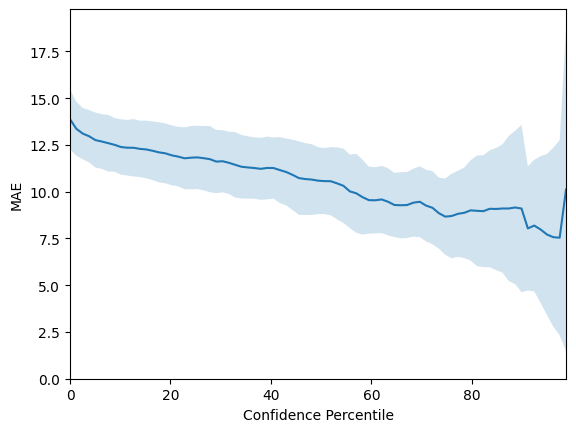

In [10]:
dataset = 'Photoswitch' # One of ['Photoswitch', 'ESOL', 'Lipophilicity', 'FreeSolv']
feature = 'ecfp_fragprints' # One of ['ecfp_frapgrints', 'ecfp_fingerprints', 'fragments']

print(f'Performing for {dataset} with feature {feature}')
loader = MolPropLoader()
loader.load_benchmark(dataset)
loader.featurize(feature)
X = loader.features
y = loader.labels

# results_all_datasets
results, fig = evaluate_model(X, y, 300, 20, 50.0, verbose=False)
fig.show()

Results for the features and datasets are shown below:

Fragprints

| |Photoswitch | Freesolv | ESOL | Lipophilicity |
|---|---|---|---|---|
| R2 | 0.8961 +- 0.0061 | 0.8682 +- 0.0071 | 0.8224 +- 0.0044 | 0.6081 +- 0.0042 |
| RMSE | 20.9166 +- 0.6331 | 1.3890 +- 0.0257  | 0.8800 +- 0.0098 |  0.7486 +- 0.0057 |
| MAE | 13.9447 +- 0.4163 | 0.9882 +- 0.0179 | 0.6622 +- 0.0079 | 0.5633 +- 0.0038 |
| NLPD | 1.6276 +- 0.4415 | 1.4109 +- 0.3837 | 1.6990 +- 0.1085 | 3.8197 +- 0.1249 |

Fingerprints

| |Photoswitch | Freesolv | ESOL | Lipophilicity |
|---|---|---|---|---|
| R2 | 0.8810 +- 0.0067 | 0.7539 +- 0.0101 | 0.7345 +- 0.0069 | 0.5447 +- 0.0040 |
| RMSE | 22.4266 +- 0.6951 | 1.9266 +- 0.0661 | 1.0764 +- 0.0157 |   0.8069 +- 0.0054 |
| MAE | 15.1349 +- 0.4448 | 1.2814 +- 0.0259 | 0.8066 +- 0.0125 | 0.6094 +- 0.0040 |
| NLPD | 2.2239 +- 0.5572 | 2.6472 +- 0.7168 | 2.5872 +- 0.3988 | 3.7413 +- 0.0994 |

Fragments 

| |Photoswitch | Freesolv | ESOL | Lipophilicity |
|---|---|---|---|---|
| R2 | 0.8434 +- 0.0075 |  0.8512 +- 0.0075 | 0.7543 +- 0.0065 | 0.4664 +- 0.0050 |
| RMSE | 25.7921 +- 0.7046 | 1.4760 +- 0.0231 | 1.0348 +- 0.0132 | 0.8735 +- 0.0056 |
| MAE | 18.8276 +- 0.4296 | 1.0239 +- 0.0127 | 0.7979 +- 0.0099 | 0.6868 +- 0.0047 |
| NLPD | 0.6944 +- 0.0908 | 0.8909 +- 0.1154 | 1.9314 +- 0.2828 | 5.5246 +- 0.2277 |